In [1]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt

# load data (hopefully we can figure out some kind of central location to store this stuff)
visitors = pd.read_csv('../data/aim_full_7_18_17/visitors.zip').fillna('')
visitors.columns = [x.strip() for x in visitors.columns]

events = pd.read_csv('../data/aim_full_7_18_17/web_events_q1_2017.csv', parse_dates=['timestamp'])
events = events.append(pd.read_csv('../data/aim_full_7_18_17/web_events_q2_2017.csv', parse_dates=['timestamp']))

devices = pd.read_csv('../data/aim_full_7_18_17/machine_fingerprints.csv')

parsed_urls = pd.read_csv('../data/aim_domain_categories_v0.csv')
parsed_urls.columns = ['url', 'category', 'sub_category', 'disease_category', 'disease']

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,5,6,7,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# sample oncologist npis, we can discuss how they would be ingested
npis = visitors[(visitors.primary_specialty.str.contains('Onc'))&(visitors.npi_number!='')].sample(1000)[['npi_number']]

In [6]:
v = pd.merge(npis, visitors, on='npi_number', how='left')

In [7]:
ev = pd.merge(v, events, on='dg_id', how='left')
ev = ev[~ev.session_id.isnull()]

In [9]:
dev = pd.merge(ev, devices, on='machine_fingerprint')

In [10]:
# platform breakdown
dev.platform.value_counts()

Win32                    960
iPhone                   252
iPad                      50
Linux armv7l              38
MacIntel                  28
Linux armv8l               6
Win64                      4
ARM                        1
BlackBerry                 1
Linux aarch64              1
Pike v7.8 release 517      1
Linux x86_64               1
Name: platform, dtype: int64

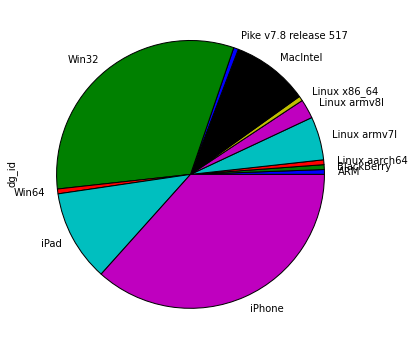

In [11]:
# viz
dev.groupby('platform').dg_id.nunique().plot.pie(figsize=(6,6))

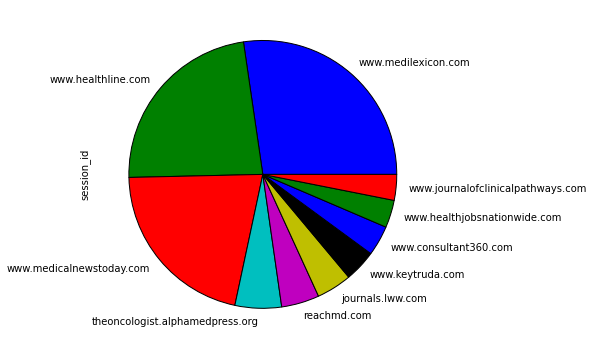

In [12]:
# breakdown of top websites visited (i know we probably can't use this)
ev.groupby('host').session_id.nunique().sort_values(ascending=False)[:10].plot.pie(figsize=(6, 6))

In [30]:
ev['hour'] = ev.timestamp.apply(lambda x: x.hour)
ev['dow'] = ev.timestamp.apply(lambda x: x.dayofweek)
ev['date']  = ev.timestamp.apply(lambda x: x.date())
ev['month'] = ev.timestamp.apply(lambda x: x.month)
ev['week'] = ev.timestamp.apply(lambda x: x.weekofyear)

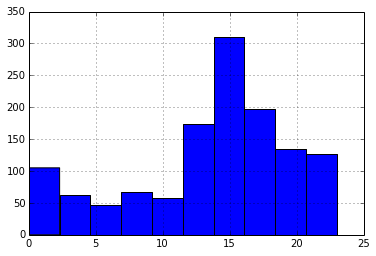

In [14]:
# when are targets most active?
ev.drop_duplicates(subset=['hour', 'session_id']).hour.hist()

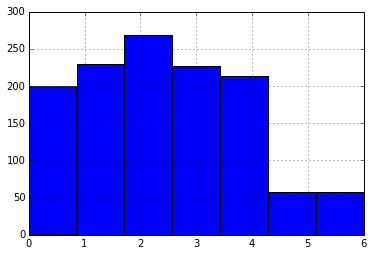

In [15]:
ev.drop_duplicates(subset=['dow', 'session_id']).dow.hist(bins=7)

In [16]:
ev = pd.merge(ev, devices[['machine_fingerprint', 'platform', 'mobile']], on='machine_fingerprint').fillna('')

/usr/local/lib/python2.7/site-packages/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


mobile
Mobile        Axes(0.125,0.125;0.775x0.775)
Non-Mobile    Axes(0.125,0.125;0.775x0.775)
dtype: object

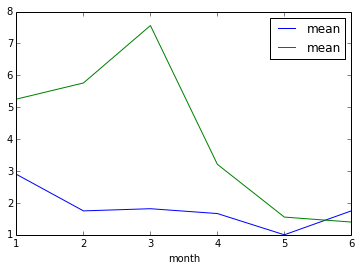

In [28]:
# mean sessions per month, split by mobile vs non-mobile (will fix legend)
fig, ax = plt.subplots(1,1)

ev.groupby(['mobile', 'month', 'dg_id']).\
    session_id.nunique().reset_index().groupby(['mobile', 'month']).\
    session_id.agg(['count', 'mean']).reset_index().groupby('mobile').plot(x='month', y='mean', ax=ax)

mobile
Mobile        Axes(0.125,0.125;0.775x0.775)
Non-Mobile    Axes(0.125,0.125;0.775x0.775)
dtype: object

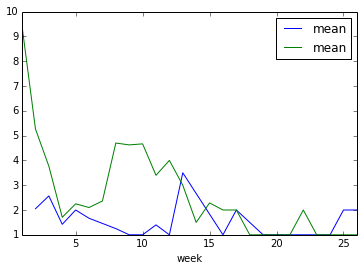

In [31]:
# mean sessions per week, split by mobile vs non-mobile (will fix legend)
fig, ax = plt.subplots(1,1)

ev.groupby(['mobile', 'week', 'dg_id']).\
    session_id.nunique().reset_index().groupby(['mobile', 'week']).\
    session_id.agg(['count', 'mean']).reset_index().groupby('mobile').plot(x='week', y='mean', ax=ax)

In [40]:
# frequency breakdown by speciatly
by_specialty = ev.groupby('primary_specialty')[['dg_id', 'session_id']].nunique()
by_specialty['sessions_per_doc'] = by_specialty.apply(lambda x: x.session_id/x.dg_id, axis=1)
by_specialty

,dg_id,session_id,sessions_per_doc
primary_specialty,,,
Gynecological Oncology,1,15,15.000000
Gynecological Oncology (GO),1,1,1.000000
Hematology/Oncology,10,39,3.900000
Hematology/Oncology (HO),51,314,6.156863
Medical Oncology,3,12,4.000000
Medical Oncology (ON),12,70,5.833333
Pediatric Hematology/Oncology (PHO),10,118,11.800000
Radiation Oncology,2,8,4.000000
Radiation Oncology (RO),17,48,2.823529


In [41]:
# see if we can pull in the url classification
parsed_urls.head()

,url,category,sub_category,disease_category,disease
0,http://www.paradigmspine.com/content/are-you-a...,Med Device,Branded Consumer,Surgery,NaN
1,http://www.paradigmspine.com/content/back-spin...,Med Device,Branded Consumer,Surgery,NaN
2,http://www.paradigmspine.com/content/coflex-study,Med Device,Branded Consumer,Surgery,NaN
3,http://www.paradigmspine.com/content/degenerat...,Med Device,Branded Consumer,Surgery,NaN
4,http://www.paradigmspine.com/content/degenerat...,Med Device,Branded Consumer,Surgery,NaN


In [42]:
parsed_urls = parsed_urls.fillna('')
parsed_urls['url'] = parsed_urls.url.apply(lambda x: x.replace('http://', ''))

In [43]:
pd.merge(ev, parsed_urls, on='url')

,npi_number,dg_id,identity_type,professional_designation,primary_specialty,primary_specialty_group,secondary_specialty,secondary_specialty_group,first_name,last_name,...,dow,date,platform,mobile,month,week,category,sub_category,disease_category,disease


^^ lol ok i expected this